In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [9]:
import pprint

import torch
import pickle
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt

from utils import utils
import deformation.losses as def_losses
from deformation.semantic_discriminator_loss import SemanticDiscriminatorLoss 
from deformation.semantic_discriminator_trainer import train

In [4]:
gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))

mesh_path = "data/test_dataset/0001old.obj"
with torch.no_grad():
    mesh = utils.load_untextured_mesh(mesh_path, device)

cfg_path = "configs/default.yaml"
cfg = utils.load_config(cfg_path)

/home/svcl-oowl/brandon/research/sil_consistent_at_inference/utils/utils.py:51: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg_special = yaml.load(f)


# Image Symmetry Loss

In [ ]:
sym_plane_normal = [0,0,1]
num_azim = 1
render_sil = False
img_sym_loss, sym_triples = def_losses.image_symmetry_loss(mesh, sym_plane_normal, num_azim, device, render_sil)
print(img_sym_loss)

In [ ]:
img_names = {0:'R1', 1:'R1_flipped', 2:'R2'}
for trip_idx, sym_triple in enumerate(sym_triples):
    fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False)
    for i in range(3):
        if render_sil:
            ax[0][i].imshow(sym_triple[i].cpu().numpy())
        else:
            ax[0][i].imshow(sym_triple[i][ ..., :3].cpu().numpy())
        ax[0][i].xaxis.set_visible(False)
        ax[0][i].yaxis.set_visible(False)
        
        ax[0][i].set_title("{}: {}".format(trip_idx, img_names[i]))

# Semantic Discriminator Loss

In [7]:
semantic_loss_computer = SemanticDiscriminatorLoss(cfg, device)
semantic_dis_loss, semantic_loss_renders = semantic_loss_computer.compute_loss(mesh)
print(semantic_dis_loss)

tensor(0.0114, device='cuda:0')


torch.Size([1, 224, 224, 4])


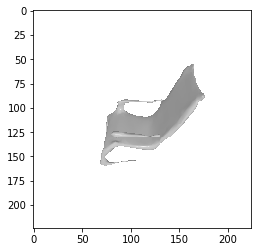

In [8]:
print(semantic_loss_renders.shape)
for render in semantic_loss_renders:
    plt.imshow(render[ ..., :3].cpu().numpy())
    plt.show()

In [12]:
training_df = train(cfg_path, gpu_num)

# Semantic Embedding Loss

In [ ]:
weights_path = "data/occnet_pretrained_weights/model_best.pt"
cfg_yaml_path = "occ_uda/configs/domain_adaptation/chair_noDA.yaml"
emb_path = "occ_uda/chair_noDA_train_latent_vecs.p"
emb_loss = def_losses.SemanticEmbeddingLoss(cfg_yaml_path, weights_path, emb_path, device)
loss, renderr = emb_loss.compute_loss(mesh)